ltv; vol; spotPrice; loanAmount; fee; reclaimable; callValue; intrinsicVal; timeVal; callDelta
80.00%; 5.00%; 1.00; 0.80; 3.83%; 0.96; 0.21; 0.20; 0.01; 1.00
80.00%; 10.00%; 1.00; 0.80; 3.83%; 0.96; 0.21; 0.20; 0.01; 1.00
80.00%; 20.00%; 1.00; 0.80; 5.02%; 0.95; 0.21; 0.20; 0.01; 0.96
80.00%; 40.00%; 1.00; 0.80; 15.53%; 0.84; 0.24; 0.20; 0.04; 0.83
85.00%; 5.00%; 1.00; 0.85; 5.34%; 0.95; 0.16; 0.15; 0.01; 1.00
85.00%; 10.00%; 1.00; 0.85; 5.43%; 0.95; 0.16; 0.15; 0.01; 0.99
85.00%; 20.00%; 1.00; 0.85; 9.33%; 0.91; 0.17; 0.15; 0.02; 0.90
85.00%; 40.00%; 1.00; 0.85; 25.48%; 0.75; 0.20; 0.15; 0.05; 0.77
90.00%; 5.00%; 1.00; 0.90; 8.22%; 0.92; 0.11; 0.10; 0.01; 1.00
90.00%; 10.00%; 1.00; 0.90; 9.42%; 0.91; 0.11; 0.10; 0.01; 0.95
90.00%; 20.00%; 1.00; 0.90; 19.70%; 0.80; 0.12; 0.10; 0.02; 0.81
90.00%; 40.00%; 1.00; 0.90; 40.99%; 0.59; 0.17; 0.10; 0.07; 0.71
95.00%; 5.00%; 1.00; 0.95; 16.71%; 0.83; 0.06; 0.05; 0.01; 0.96
95.00%; 10.00%; 1.00; 0.95; 25.11%; 0.75; 0.07; 0.05; 0.02; 0.82
95.00%;

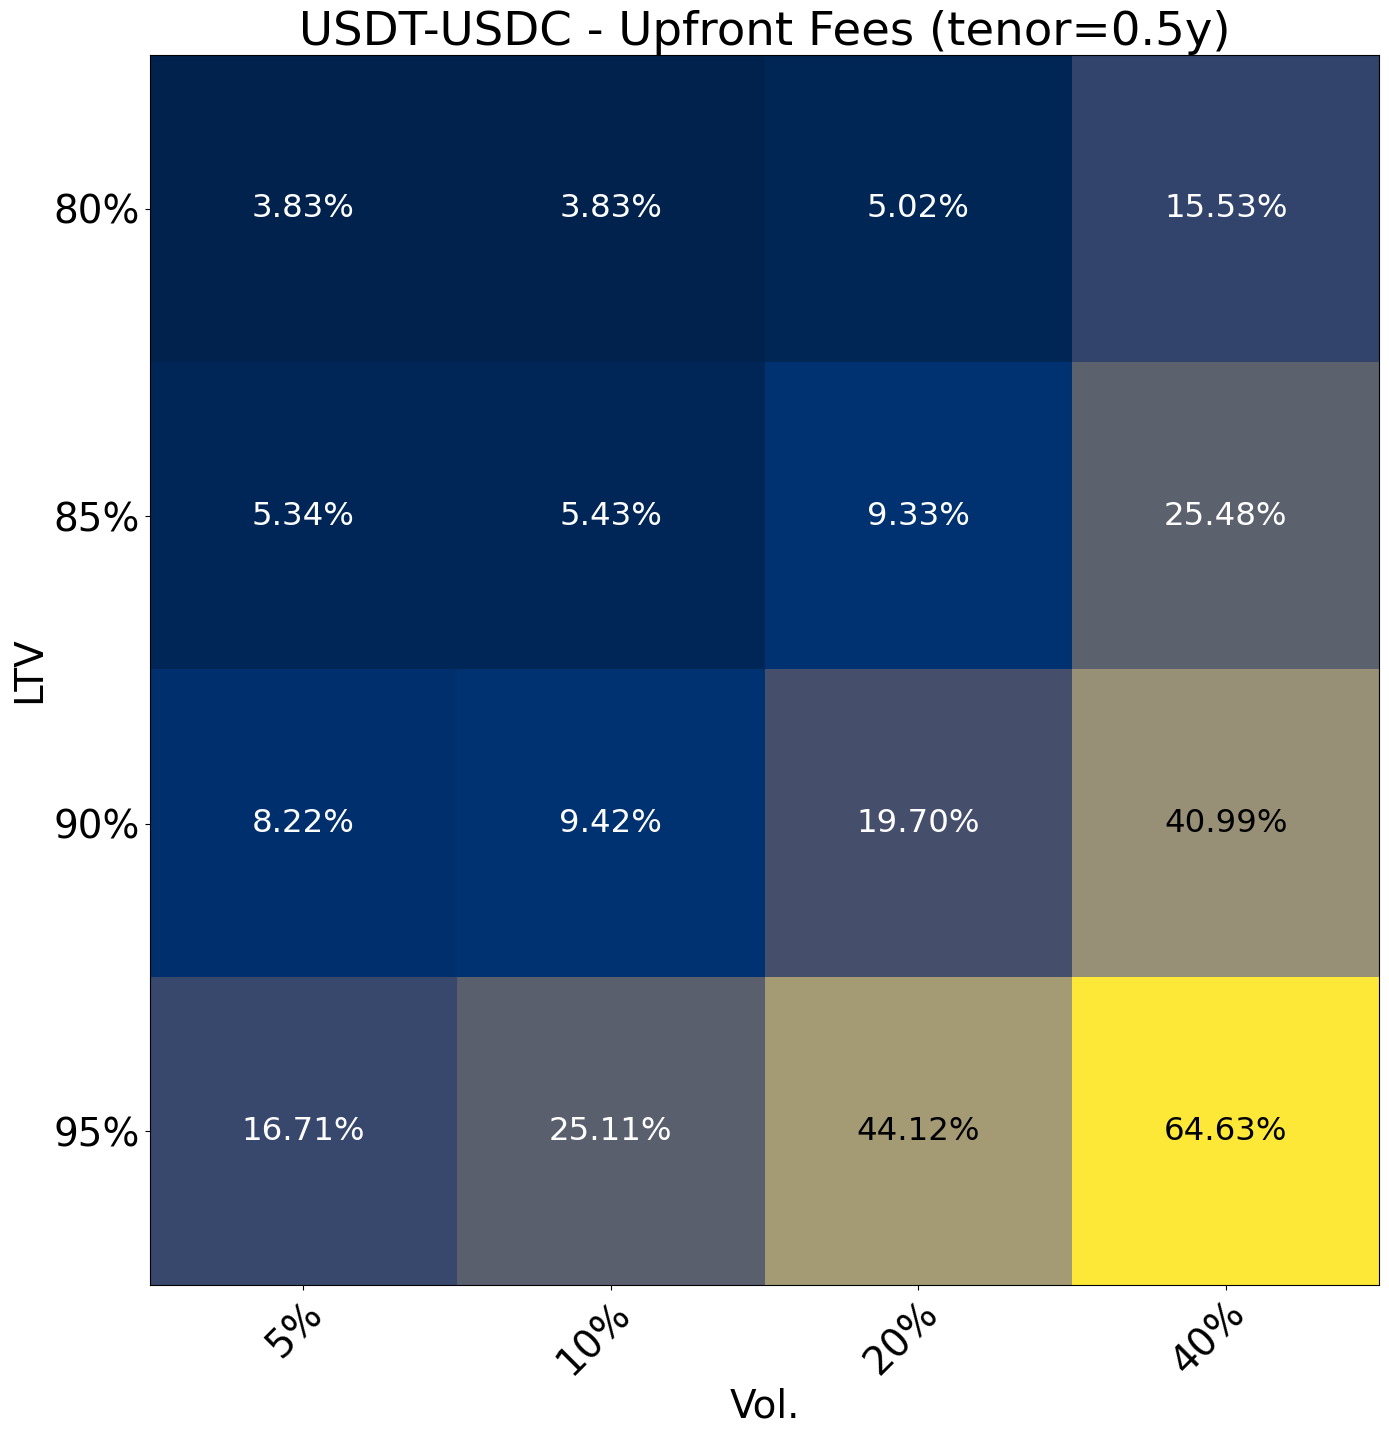

ltv; vol; spotPrice; loanAmount; apr; strike; callValue; intrinsicVal; timeVal; callDelta
80.00%; 5.00%; 1.00; 0.80; 2.01%; 0.81; 0.20; 0.19; 0.01; 1.00
80.00%; 10.00%; 1.00; 0.80; 2.01%; 0.81; 0.20; 0.19; 0.01; 1.00
80.00%; 20.00%; 1.00; 0.80; 2.85%; 0.81; 0.20; 0.19; 0.01; 0.95
80.00%; 40.00%; 1.00; 0.80; 12.98%; 0.85; 0.20; 0.15; 0.05; 0.77
85.00%; 5.00%; 1.00; 0.85; 2.01%; 0.86; 0.15; 0.14; 0.01; 1.00
85.00%; 10.00%; 1.00; 0.85; 2.07%; 0.86; 0.15; 0.14; 0.01; 0.99
85.00%; 20.00%; 1.00; 0.85; 4.27%; 0.87; 0.15; 0.13; 0.02; 0.87
85.00%; 40.00%; 1.00; 0.85; 19.75%; 0.93; 0.15; 0.07; 0.08; 0.66
90.00%; 5.00%; 1.00; 0.90; 2.01%; 0.91; 0.10; 0.09; 0.01; 1.00
90.00%; 10.00%; 1.00; 0.90; 2.50%; 0.91; 0.10; 0.09; 0.01; 0.93
90.00%; 20.00%; 1.00; 0.90; 7.55%; 0.93; 0.10; 0.07; 0.03; 0.73
90.00%; 40.00%; 1.00; 0.90; 31.06%; 1.04; 0.10; 0.00; 0.10; 0.52
95.00%; 5.00%; 1.00; 0.95; 2.27%; 0.96; 0.05; 0.04; 0.01; 0.92
95.00%; 10.00%; 1.00; 0.95; 4.78%; 0.97; 0.05; 0.03; 0.02; 0.71
95.00%; 20.00%;

<Figure size 640x480 with 0 Axes>

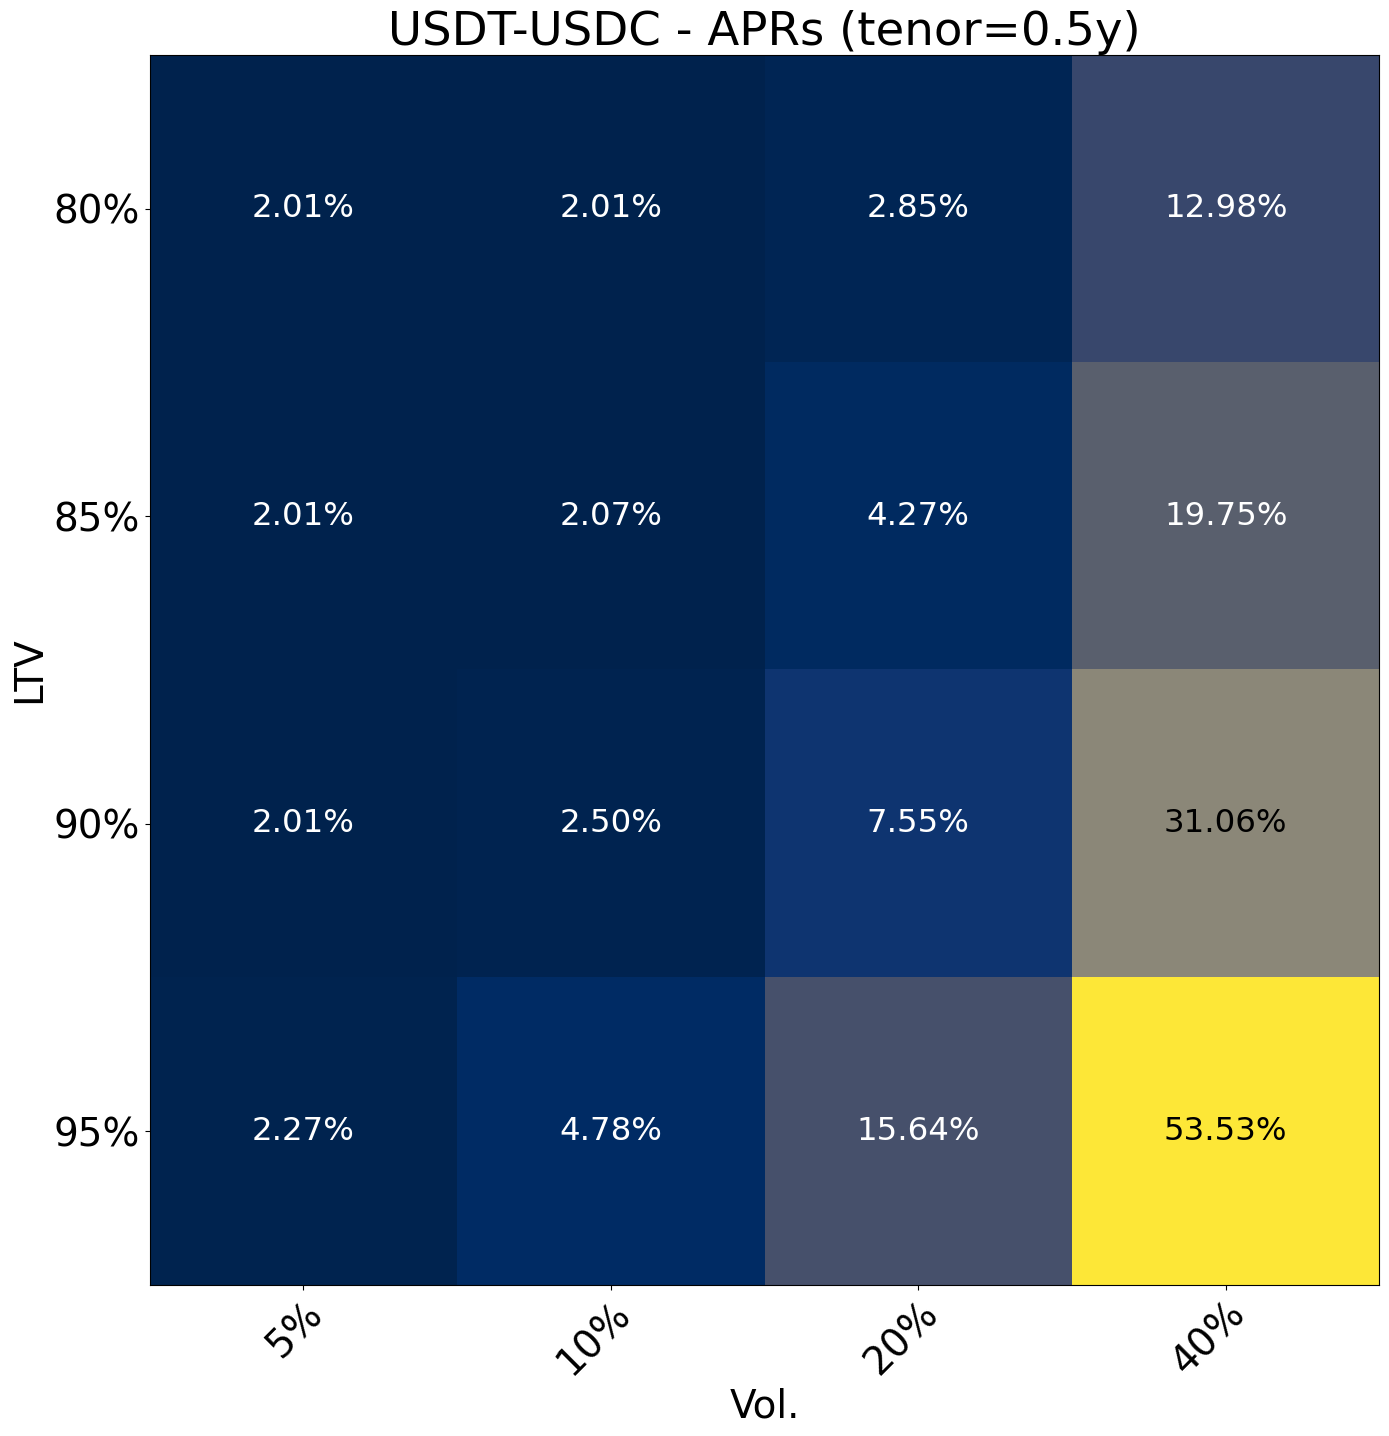

<Figure size 640x480 with 0 Axes>

In [10]:
import numpy as np
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt

CMAP = "cividis"

def getD1(S, K, vol, dt, r):
    return (np.log(S / K) + (r + vol**2 / 2) * dt) / \
        (vol * np.sqrt(dt))

def getCallPrice(spotPrice, strikePrice, vol, dt,riskFreeRate):
    if dt <= 0:
        return max([0, spotPrice - strikePrice])
    if strikePrice <= 0:
        return spotPrice
    d1 = getD1(spotPrice, strikePrice, vol, dt, riskFreeRate)
    d2 = d1 - vol * np.sqrt(dt)
    value = spotPrice * norm.cdf(d1) - strikePrice * \
        np.exp(-riskFreeRate * dt) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return value, delta

def getEquilibriumFee(loanAmount, spotPrice, vol, riskFreeRate, loanTenorInYears):
    def getSwapValue(fee):
        callPrice, _ = getCallPrice(spotPrice, loanAmount, vol, loanTenorInYears, riskFreeRate)
        swapValue = -1*spotPrice + loanAmount + callPrice*(1-fee)
        return swapValue
    
    def minFunc(fee):
        swapValue = getSwapValue(fee)
        return swapValue**2

    initFeeGuess = .5
    feeBnds = (.0, 1.)
    res = optimize.minimize(
        minFunc,
        args=(),
        x0=[initFeeGuess],
        bounds=[feeBnds])
        
    callPrice, callDelta = getCallPrice(spotPrice, loanAmount, vol, loanTenorInYears, riskFreeRate)
    intrinsicVal = max([spotPrice - loanAmount, 0])
    timeVal = callPrice - intrinsicVal

    if res["success"] and res["fun"] < 0.1:
        fee = res['x'][0]
    else:
        fee = None
        
    return fee, callPrice, intrinsicVal, timeVal, callDelta

def getEquilibriumApr(loanAmount, spotPrice, vol, riskFreeRate, loanTenorInYears):
    def getSwapValue(strike):
        callPrice, _ = getCallPrice(spotPrice, strike, vol, loanTenorInYears, riskFreeRate)
        swapValue = -1*spotPrice + loanAmount + callPrice
        return swapValue
    
    def minFunc(strike):
        swapValue = getSwapValue(strike)
        return swapValue**2

    initStrikeGuess = spotPrice
    strikeBnds = (.0000001, None)
    res = optimize.minimize(
        minFunc,
        args=(),
        x0=[initStrikeGuess],
        bounds=[strikeBnds])
        
    strike = res['x'][0]
    callPrice, callDelta = getCallPrice(spotPrice, strike, vol, loanTenorInYears, riskFreeRate)
    intrinsicVal = max([spotPrice - strike, 0])
    timeVal = callPrice - intrinsicVal
    
    if res["success"] and res["fun"] < 0.1:
        strike = res['x'][0]
        apr = (strike/loanAmount-1)/loanTenorInYears
    else:
        strike = None
        apr = None
        
    return strike, apr, callPrice, intrinsicVal, timeVal, callDelta

def upfrontFeeHeatmap(params):
    print("ltv; vol; spotPrice; loanAmount; fee; reclaimable; callValue; intrinsicVal; timeVal; callDelta")
    feeRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["loanAmount"] = params["spotPrice"]*ltv
        for vol in params["volRange"]:
            args = dict((k, params[k]) for k in ("loanAmount", "spotPrice", "riskFreeRate", "loanTenorInYears"))
            args["vol"] = vol
            (fee, callPrice, intrinsicVal, timeVal, callDelta) = getEquilibriumFee(**args)
            tmp.append(fee)
            print("{:.2f}%; {:.2f}%; {:.2f}; {:.2f}; {:.2f}%; {:.2f}; {:.2f}; {:.2f}; {:.2f}; {:.2f}".format(ltv*100, vol*100, params["spotPrice"], params["loanAmount"], fee*100, 1-fee, callPrice, intrinsicVal, timeVal, callDelta))
        feeRes.append(tmp)
    print(feeRes)
    
    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(feeRes, cmap=CMAP)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["volRange"])), labels=["{:.0f}%".format(x*100) for x in params["volRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(feeRes), vmax=np.max(feeRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["volRange"])):
            bg = cmap(normColors(feeRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(feeRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")
    
    ax.set_title("{} - Upfront Fees (tenor={:.1f}y)".format(params["pair"], params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} - fees.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()
    
def aprHeatmap(params):
    print("ltv; vol; spotPrice; loanAmount; apr; strike; callValue; intrinsicVal; timeVal; callDelta")
    aprRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["loanAmount"] = params["spotPrice"]*ltv
        for vol in params["volRange"]:
            args = dict((k, params[k]) for k in ("loanAmount", "spotPrice", "riskFreeRate", "loanTenorInYears"))
            args["vol"] = vol
            (strike, apr, callPrice, intrinsicVal, timeVal, callDelta) = getEquilibriumApr(**args)
            tmp.append(apr)
            print("{:.2f}%; {:.2f}%; {:.2f}; {:.2f}; {:.2f}%; {:.2f}; {:.2f}; {:.2f}; {:.2f}; {:.2f}".format(ltv*100, vol*100, params["spotPrice"], params["loanAmount"], apr*100, strike, callPrice, intrinsicVal, timeVal, callDelta))
        aprRes.append(tmp)
    print(aprRes)
    
    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(aprRes, cmap=CMAP)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["volRange"])), labels=["{:.0f}%".format(x*100) for x in params["volRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(aprRes), vmax=np.max(aprRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["volRange"])):
            bg = cmap(normColors(aprRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(aprRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")
    
    ax.set_title("{} - APRs (tenor={:.1f}y)".format(params["pair"], params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} - aprs.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()

if __name__ == "__main__":
    params = {
        "pair": "RPL-USDC",
        "ltvRange": [.1, .25, .5, .75],
        "volRange": [.5, 1., 1.5, 2.],
        "spotPrice": 30.,
        "riskFreeRate": .02,
        "loanTenorInYears": 1./2
    }
    params = {
        "pair": "USDT-USDC",
        "ltvRange": [.8, .85, .9, .95],
        "volRange": [.05, .1, .2, .4],
        "spotPrice": 1.,
        "riskFreeRate": .02,
        "loanTenorInYears": 1./2
    }
    upfrontFeeHeatmap(params)
    aprHeatmap(params)
